In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
dtype = {
    'store_nbr' : 'category',
    'family' : 'category',
    'sales' : 'float32',
    'onpromotion' : 'uint64'
}
train_data = pd.read_csv("C://Users//user//Documents//Store Sales//train.csv",
                         usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                         dtype= dtype, parse_dates=['date'],
                        infer_datetime_format=True)
train_data = train_data.set_index('date').to_period('D')
train_data = train_data.set_index(['store_nbr', 'family'], append=True)
train_data

sales  onpromotion
date       store_nbr family                                              
2013-01-01 1         AUTOMOTIVE                     0.000000            0
                     BABY CARE                      0.000000            0
                     BEAUTY                         0.000000            0
                     BEVERAGES                      0.000000            0
                     BOOKS                          0.000000            0
...                                                      ...          ...
2017-08-15 9         POULTRY                      438.132996            0
                     PREPARED FOODS               154.552994            1
                     PRODUCE                     2419.729004          148
                     SCHOOL AND OFFICE SUPPLIES   121.000000            8
                     SEAFOOD                       16.000000            0

[3000888 rows x 2 columns]

In [40]:
average_sales = train_data.groupby('date').mean()['sales']
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

In [41]:
average_sales.isnull().sum()

0

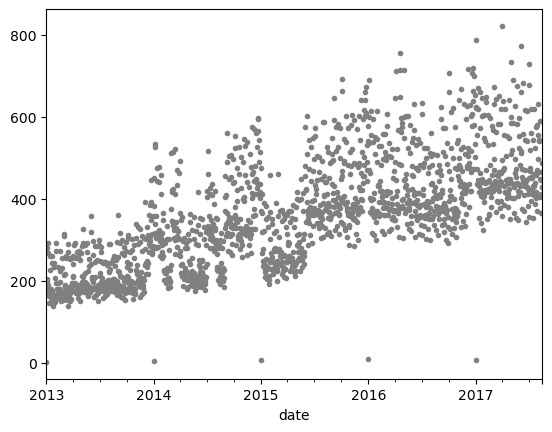

In [42]:
ax = average_sales.plot(style='.', color='0.5')

<AxesSubplot:xlabel='date'>

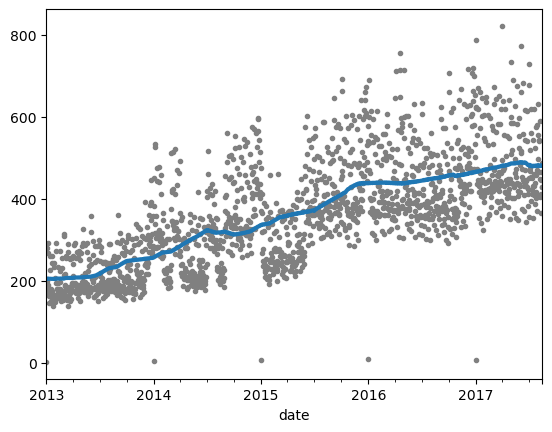

In [43]:
moving_average = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()
ax = average_sales.plot(style='.', color='0.5')
moving_average.plot(ax=ax, linewidth=3)

In [44]:
dp = DeterministicProcess(
    index=average_sales.index,
    constant=True,
    order=3,
    drop=True,
)
X = dp.in_sample()
X

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.000000e+00
2013-01-02,1.0,2.0,4.0,8.000000e+00
2013-01-03,1.0,3.0,9.0,2.700000e+01
2013-01-04,1.0,4.0,16.0,6.400000e+01
2013-01-05,1.0,5.0,25.0,1.250000e+02
...,...,...,...,...
2017-08-11,1.0,1680.0,2822400.0,4.741632e+09
2017-08-12,1.0,1681.0,2825761.0,4.750104e+09
2017-08-13,1.0,1682.0,2829124.0,4.758587e+09


In [45]:
y = average_sales.copy()
y

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

In [46]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index = X.index)

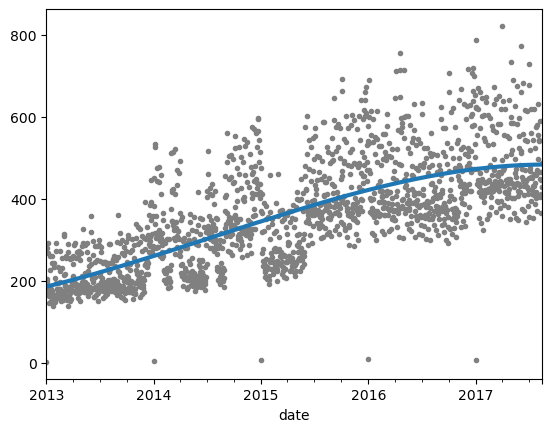

In [47]:
ax = average_sales.plot(style='.', color='0.5')
_ = y_pred.plot(ax=ax, linewidth=3)

In [48]:
X = dp.out_of_sample(30)
y_fore = pd.Series(model.predict(X), index=X.index)

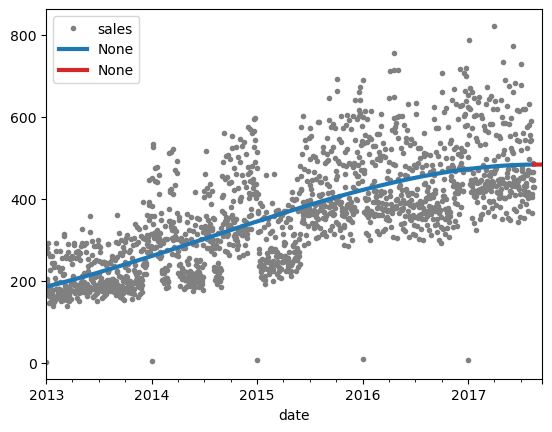

In [49]:
ax = average_sales.plot(style='.', color='0.5')
ax = y_pred.plot(ax=ax, linewidth=3)
ax = y_fore.plot(ax=ax, linewidth=3, color='C3')
ax.legend()

In [50]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

,sales,week,day,dayofyear,year
date,,,,,
2013-01-01,1.409438,1,1,1,2013
2013-01-02,278.390808,1,2,2,2013
2013-01-03,202.840195,1,3,3,2013
2013-01-04,198.911148,1,4,4,2013
2013-01-05,267.873230,1,5,5,2013
...,...,...,...,...,...
2017-08-11,463.733856,32,4,223,2017
2017-08-12,444.798279,32,5,224,2017
2017-08-13,485.768616,32,6,225,2017


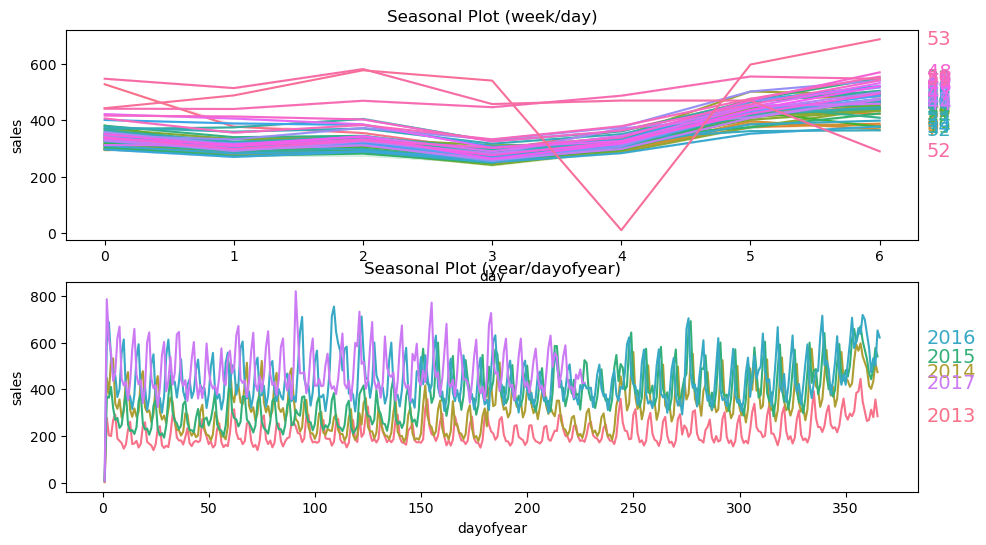

In [51]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);
X

C:\Users\user\AppData\Local\Temp\ipykernel_16860\841079489.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(average_sales)


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

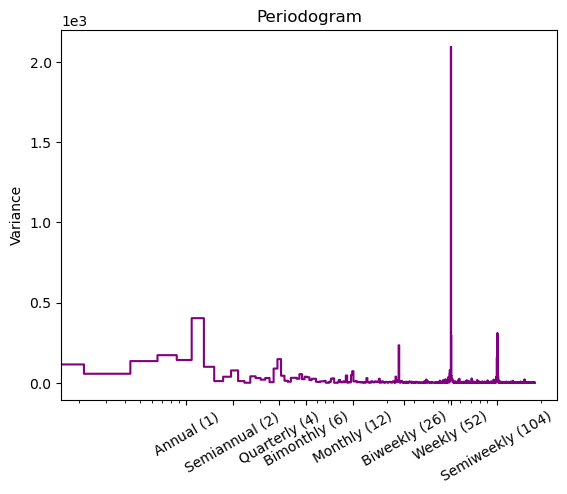

In [52]:
plot_periodogram(average_sales)

In [53]:
fourier = CalendarFourier(freq='A', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
date,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.628763,-0.777597,0.977848,0.209315,-0.891981,0.452072,0.409356,-0.912375
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.642055,-0.766659,0.984474,0.175531,-0.867456,0.497513,0.345612,-0.938377
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,0.989932,0.141540,-0.840618,0.541628,0.280231,-0.959933


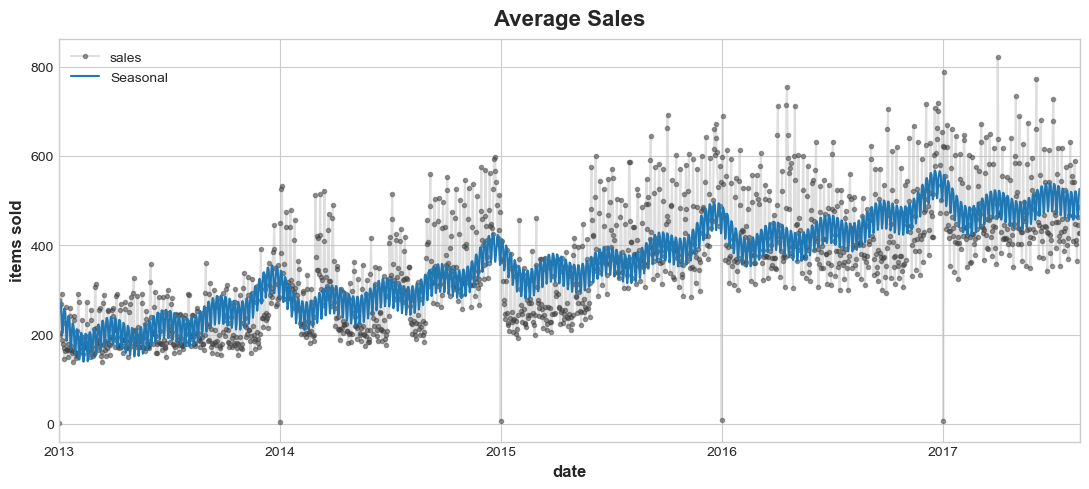

In [54]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [3]:
dtype = {
    'store_nbr' : 'category',
    'family' : 'category',
    'onpromotion' : 'uint64'
}
test_data = pd.read_csv("C://Users//user//Documents//Store Sales//test.csv",
                         dtype= dtype, parse_dates=['date'],
                        infer_datetime_format=True)
test_data = test_data.set_index('date').to_period('D')
test_data = test_data.set_index(['store_nbr', 'family'], append=True)
test_data

id  onpromotion
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888            0
                     BABY CARE                   3000889            0
                     BEAUTY                      3000890            2
                     BEVERAGES                   3000891           20
                     BOOKS                       3000892            0
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395            1
                     PREPARED FOODS              3029396            0
                     PRODUCE                     3029397            1
                     SCHOOL AND OFFICE SUPPLIES  3029398            9
                     SEAFOOD                     3029399            0

[28512 rows x 2 columns]

In [56]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
date,,,,,,,,,,,,,,,,
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.693281,-0.720667,0.999250,0.038722,-0.746972,0.664855,0.077386,-0.997001
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.705584,-0.708627,0.999991,0.004304,-0.711657,0.702527,0.008607,-0.999963
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.717677,-0.696376,0.999546,-0.030120,-0.674444,0.738326,-0.060213,-0.998186
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729558,-0.683919,0.997917,-0.064508,-0.635432,0.772157,-0.128748,-0.991677
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.741222,-0.671260,0.995105,-0.098820,-0.594727,0.803928,-0.196673,-0.980469
2017-08-21,1.0,1690.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.752667,-0.658402,0.991114,-0.133015,-0.552435,0.833556,-0.263665,-0.964614
2017-08-22,1.0,1691.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.763889,-0.645348,0.985948,-0.167052,-0.508671,0.860961,-0.329408,-0.944188
2017-08-23,1.0,1692.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.774884,-0.632103,0.979614,-0.200891,-0.463550,0.886071,-0.393590,-0.919286
2017-08-24,1.0,1693.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.785650,-0.618671,0.972118,-0.234491,-0.417194,0.908818,-0.455907,-0.890028


In [57]:
y = train_data.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
y_pred

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-01-01   1.765397       0.0  1.878898  1070.645255  0.560145   187.388222   
2017-01-02   4.079200       0.0  3.609793  2390.697187  0.627466   425.536101   
2017-01-03   3.967442       0.0  3.735080  2525.305827  0.965860   421.781146   
2017-01-04   4.065468       0.0  3.603507  2709.553597  1.063590   497.962041   
2017-01-05   3.925240       0.0  3.107353  2341.551931  0.787991   442.750775   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   6.255772       0.0  3.618540  2285.313096  0.433766   351.545106   
2017-08-12   5.373726       0.0  4.278236  2426.128017  0.197833   369.023065   
2017-08-13   2.488187       0.0  2.039453   947.879104  0.144902   112.783123   
2017-08-14   4.381333       0.0  3.563143  2167.871646  0.127627   337.063640   
2017-08-15   4.136249       0.0  3.652089  2246.202303  0.405899   323.866908   

                                                            ... onpromotion  \
store_nbr                                                   ...           9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                        ...               
2017-01-01    2.367380  281.353516  397.210503   73.398371  ...         0.0   
2017-01-02   12.676740  718.888945  818.624615  155.737751  ...         0.0   
2017-01-03   14.891045  854.231997  830.070207  151.741886  ...         0.0   
2017-01-04   15.474657  962.608308  975.875339  156.913529  ...         0.0   
2017-01-05   19.012154  792.496314  820.733094  131.281480  ...         0.0   
...                ...         ...         ...         ...  ...         ...   
2017-08-11   22.863347  694.303182  752.851278  163.872304  ...         0.0   
2017-08-12   15.491724  590.103057  758.057952  136.939419  ...         0.0   
2017-08-13    5.096150  177.178932  279.085908   53.075854  ...         0.0   
2017-08-14   14.848330  588.015324  675.558052  134.372583  ...         0.0   
2017-08-15   16.762616  714.518337  676.301456  132.715912  ...         0.0   

                                                                          \
store_nbr                                                                  
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-01-01   0.260087     15.443319     0.069994                0.121471   
2017-01-02   0.137185     14.605873     0.030126               -0.020277   
2017-01-03   0.464718     14.152505    -0.007744               -0.017017   
2017-01-04   0.250417     15.206503     0.081195                0.000822   
2017-01-05  20.244634     14.226900     0.022985               -0.028773   
...               ...           ...          ...                     ...   
2017-08-11   0.664411     10.633817     0.030693                0.085651   
2017-08-12   0.835935     11.490098     0.052849                0.036775   
2017-08-13   0.803859     11.741035     0.034089                0.148348   
2017-08-14   0.536682     11.893635    -0.013938                0.044679   
2017-08-15   0.705649     12.257135    -0.056973                0.076182   

                                                                             \
store_nbr                                                                     
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2017-01-01   0.745402       2.003841    1.710874                  -0.627640   
2017-01-02   0.705622       1.768588    1.753837                  -0.651399   

In [60]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(test_data.id).reindex(columns=['id', 'sales'])
y_submit
#y_submit.to_csv('C:\\Users\\user\\Documents\\Store Sales\\submission.csv', index=False)

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- cos(1,freq=A-DEC)
- cos(2,freq=A-DEC)
- cos(3,freq=A-DEC)
- cos(4,freq=A-DEC)
- sin(1,freq=A-DEC)
- ...
Feature names seen at fit time, yet now missing:
- cos(1,freq=M)
- cos(2,freq=M)
- cos(3,freq=M)
- cos(4,freq=M)
- sin(1,freq=M)
- ...

  warnings.warn(message, FutureWarning)


id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888    13.132484
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     4.403621
                     BEVERAGES                   3000891  1315.336964
                     BOOKS                       3000892    -4.540699
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   311.749907
                     PREPARED FOODS              3029396     5.206590
                     PRODUCE                     3029397    40.348264
                     SCHOOL AND OFFICE SUPPLIES  3029398   412.854796
                     SEAFOOD                     3029399    46.154530

[28512 rows x 2 columns]

In [62]:
family_sales = (train_data.groupby(['family', 'date']).mean().unstack('family'))
family_sales

sales                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2013-01-01   0.000000  0.000000  0.037037    15.000000  0.000000     3.344241   
2013-01-02   4.722222  0.000000  3.833333  1335.036987  0.000000   486.042938   
2013-01-03   2.981482  0.000000  2.314815   964.907410  0.000000   341.786682   
2013-01-04   3.129630  0.000000  2.462963  1003.092590  0.000000   309.666077   
2013-01-05   6.333333  0.000000  3.537037  1441.074097  0.000000   414.217804   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   8.166667  0.129630  6.500000  3502.055664  0.000000   522.305298   
2017-08-12   7.462963  0.055556  6.833333  3376.259277  0.000000   507.473114   
2017-08-13   8.907408  0.166667  8.018518  3747.296387  0.018519   615.976990   
2017-08-14   5.407407  0.166667  6.240741  3237.629639  0.000000   518.564026   
2017-08-15   6.240741  0.148148  6.277778  3162.462891  0.000000   539.966553   

                                                             ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2013-01-01    0.000000     3.444444    2.648148    1.316481  ...         0.0   
2013-01-02    0.000000  1382.018555  432.981476  291.750000  ...         0.0   
2013-01-03    0.000000  1035.055542  333.351837  206.897308  ...         0.0   
2013-01-04    0.000000   964.148132  336.074066  187.837204  ...         0.0   
2013-01-05    0.000000  1298.666626  427.444458  254.350830  ...         0.0   
...                ...          ...         ...         ...  ...         ...   
2017-08-11   16.111111  1031.148193  831.648132  345.934967  ...         0.0   
2017-08-12   15.722222  1072.870361  793.592590  290.553589  ...         0.0   
2017-08-13   10.074074  1143.648193  928.000000  325.801361  ...         0.0   
2017-08-14   11.000000  1019.111084  797.222229  271.532227  ...         0.0   
2017-08-15   11.055555  1082.851807  753.833313  276.582458  ...         0.0   

                                                                          \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2013-01-01   0.000000      0.000000          0.0                0.000000   
2013-01-02   0.000000      0.000000          0.0                0.000000   
2013-01-03   0.000000      0.000000          0.0                0.000000   
2013-01-04   0.000000      0.000000          0.0                0.000000   
2013-01-05   0.000000      0.000000          0.0                0.000000   
...               ...           ...          ...                     ...   
2017-08-11  22.925926      9.000000          0.0                0.000000   
2017-08-12   0.000000      8.703704          0.0                0.018519   
2017-08-13   0.000000      9.240741          0.0                0.000000   
2017-08-14   0.000000      8.722222          0.0                0.000000   
2017-08-15   0.000000      8.814815          0.0                0.092593   

                                                                            \
family        POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                         
2013-01-01   0.000000       0.000000   0.000000                   0.000000   
2013-01-02   0.000000       0.000000   0.000000                   0.000000   
2013-01-03   0.000000       0.000000   0.000000                   0.000000   
2013-01-04   0.000000       0.000000   0.000000                   0.000000   
2013-01-05   0.000000       0.000000   0.000000                   0.000000   
...               ...            ...        ...                        

In [4]:
total_sales = train_data.unstack(['store_nbr', 'family'])
total_sales

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...           0     0   
2013-01-02         0.0   1060.0  579.0  164.069000  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582001  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.410995  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.612999  ...           0     0   
...                ...      ...    ...         ...  ...         ...   ...   
2017-08-11         4.0    341.0  343.0   64.302002  ...           0     0   
2017-08-12         3.0    351.0  526.0   99.487999  ...           0     0   
2017-08-13         1.0    169.0  266.0   47.770000  ...           0     0   
2017-08-14         4.0    571.0  699.0  154.578003  ...           0     0   
2017-08-15        21.0    703.0  602.0  116.402000  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0   
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   
...                  ...          ...                     ...     ...   
2017-08-11            11            0                       0      22   
2017-08-12             7            0                       0       0   
2017-08-13             9            0                       0       0   
2017-08-14            10            0                       0       0   
2017-08-15            11            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  
...                   ...     ...                        ..

In [5]:
dp = DeterministicProcess(index=total_sales.index, order=1)
X_1 = dp.in_sample()

In [6]:
X_1

,trend
date,
2013-01-01,1.0
2013-01-02,2.0
2013-01-03,3.0
2013-01-04,4.0
2013-01-05,5.0
...,...
2017-08-11,1680.0
2017-08-12,1681.0
2017-08-13,1682.0


In [7]:
id_train, id_valid = train_test_split(total_sales.index, train_size=0.8, test_size=0.2, shuffle=False, random_state=0)

In [8]:
X_train_1, X_valid_1 = X_1.loc[id_train, :], X_1.loc[id_valid, :]
y_train, y_valid = total_sales.loc[id_train], total_sales.loc[id_valid]

In [9]:
y_train

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   
...               ...       ...    ...       ...   ...          ...   
2016-09-07        8.0       0.0    3.0    2060.0   0.0   496.806000   
2016-09-08        3.0       0.0    3.0    1946.0   0.0   433.609985   
2016-09-09        4.0       0.0    8.0    2451.0   0.0   406.704987   
2016-09-10        2.0       0.0    7.0    2251.0   0.0   427.588013   
2016-09-11        0.0       0.0    3.0     864.0   0.0   150.559006   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...           0     0   
2013-01-02         0.0   1060.0  579.0  164.069000  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582001  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.410995  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.612999  ...           0     0   
...                ...      ...    ...         ...  ...         ...   ...   
2016-09-07        17.0    839.0  859.0  134.014999  ...           0     0   
2016-09-08        24.0    727.0  734.0  138.942001  ...           0    20   
2016-09-09        28.0    677.0  810.0  136.149994  ...           0     0   
2016-09-10        16.0    638.0  820.0  130.998993  ...           0     0   
2016-09-11         5.0    230.0  297.0   58.715000  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0   
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   
...                  ...          ...                     ...     ...   
2016-09-07             7            0                       0       0   
2016-09-08            11            0                       0       0   
2016-09-09            10            0                       0      17   
2016-09-10            10            0                       0       0   
2016-09-11            11            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  
...                   ...     ...                        ..

In [10]:
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train)

LinearRegression()

In [66]:
model_11 = Ridge()
model_11.fit(X_train_1, y_train)

Ridge()

In [137]:
model_12 = Lasso()
model_12.fit(X_train_1, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [114]:
model_13 = ElasticNet()
model_13.fit(X_train_1, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


ElasticNet()

In [11]:
y_fit = pd.DataFrame(
        model_1.predict(X_train_1),
        index=X_train_1.index, columns=total_sales.columns,
    )
y_pred = pd.DataFrame(
        model_1.predict(X_valid_1),
        index=X_valid_1.index, columns=total_sales.columns,
    )

In [12]:
y_pred

sales                                                      \
store_nbr           1                                                       
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2016-09-12   4.428572       0.0  2.673199  2136.488319   0.0   408.826481   
2016-09-13   4.430600       0.0  2.673946  2137.523817   0.0   408.943238   
2016-09-14   4.432628       0.0  2.674692  2138.559314   0.0   409.059995   
2016-09-15   4.434657       0.0  2.675439  2139.594812   0.0   409.176753   
2016-09-16   4.436685       0.0  2.676186  2140.630310   0.0   409.293510   
...               ...       ...       ...          ...   ...          ...   
2017-08-11   5.101909       0.0  2.921062  2480.273622   0.0   447.589908   
2017-08-12   5.103937       0.0  2.921809  2481.309120   0.0   447.706665   
2017-08-13   5.105965       0.0  2.922555  2482.344618   0.0   447.823423   
2017-08-14   5.107993       0.0  2.923302  2483.380116   0.0   447.940180   
2017-08-15   5.110021       0.0  2.924049  2484.415614   0.0   448.056937   

                                                            ... onpromotion  \
store_nbr                                                   ...           9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                        ...               
2016-09-12   18.168260  670.248245  792.799136  138.412750  ...         0.0   
2016-09-13   18.182519  670.301028  793.084882  138.439372  ...         0.0   
2016-09-14   18.196779  670.353811  793.370628  138.465994  ...         0.0   
2016-09-15   18.211038  670.406594  793.656374  138.492616  ...         0.0   
2016-09-16   18.225297  670.459377  793.942120  138.519238  ...         0.0   
...                ...         ...         ...         ...  ...         ...   
2017-08-11   22.902326  687.772151  887.666783  147.251282  ...         0.0   
2017-08-12   22.916586  687.824934  887.952529  147.277904  ...         0.0   
2017-08-13   22.930845  687.877716  888.238275  147.304526  ...         0.0   
2017-08-14   22.945104  687.930499  888.524021  147.331148  ...         0.0   
2017-08-15   22.959363  687.983282  888.809767  147.357770  ...         0.0   

                                                                         \
store_nbr                                                                 
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2016-09-12  4.044348      5.441084     0.048789                0.030615   
2016-09-13  4.047414      5.446799     0.048842                0.030647   
2016-09-14  4.050481      5.452515     0.048894                0.030679   
2016-09-15  4.053547      5.458231     0.048947                0.030711   
2016-09-16  4.056613      5.463946     0.049000                0.030743   
...              ...           ...          ...                     ...   
2017-08-11  5.062327      7.338689     0.066240                0.041306   
2017-08-12  5.065393      7.344405     0.066292                0.041339   
2017-08-13  5.068460      7.350121     0.066345                0.041371   
2017-08-14  5.071526      7.355836     0.066397                0.041403   
2017-08-15  5.074592      7.361552     0.066450                0.041435   

                                                                           \
store_nbr                                                                   
family       POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                        
2016-09-12  3.883242       2.088197  22.586894                   0.645541   
2016-09-13  3.886074       2.090208  22.606855                   0.646232   
2016-09-14  3.888907       2.092219  22.626815                   0.646924   
2016-09-1

In [13]:
y_pred = y_pred.stack(['store_nbr', 'family'])
y_pred

onpromotion        sales
date       store_nbr family                                              
2016-09-12 1         AUTOMOTIVE                     0.037775     4.428572
                     BABY CARE                      0.000000     0.000000
                     BEAUTY                         0.151971     2.673199
                     BEVERAGES                     13.295111  2136.488319
                     BOOKS                          0.000000     0.000000
...                                                      ...          ...
2017-08-15 9         POULTRY                        4.835022   519.113917
                     PREPARED FOODS                 2.763914   112.945668
                     PRODUCE                       29.293566  2271.320247
                     SCHOOL AND OFFICE SUPPLIES     0.877791    16.533502
                     SEAFOOD                        0.964325    17.834491

[600534 rows x 2 columns]

In [14]:
X_2 = total_sales.drop('sales', axis=1)
X_2 = X_2.stack(['store_nbr', 'family'])
le = LabelEncoder()
X_2 = X_2.reset_index(['store_nbr', 'family'])
X_2['family'] = le.fit_transform(X_2['family'])
X_2['day'] = X_2.index.day
X_2 = X_2.drop('store_nbr', axis=1)
X_2

,family,onpromotion,day
date,,,
2013-01-01,0,0,1
2013-01-01,1,0,1
2013-01-01,2,0,1
2013-01-01,3,0,1
2013-01-01,4,0,1
...,...,...,...
2017-08-15,28,0,15
2017-08-15,29,1,15
2017-08-15,30,148,15


In [15]:
y_resid = y_train - y_fit
y_resid = y_resid.stack(['store_nbr', 'family']).squeeze()
y_valid = y_valid.stack(['store_nbr', 'family'])
y_valid
y_resid_valid = y_valid - y_pred
y_resid_valid

onpromotion       sales
date       store_nbr family                                             
2016-09-12 1         AUTOMOTIVE                    -0.037775   -0.428572
                     BABY CARE                      0.000000    0.000000
                     BEAUTY                        -0.151971    3.326801
                     BEVERAGES                     -3.295111  316.511681
                     BOOKS                          0.000000    0.000000
...                                                      ...         ...
2017-08-15 9         POULTRY                       -4.835022  -80.980922
                     PREPARED FOODS                -1.763914   41.607326
                     PRODUCE                      118.706434  148.408757
                     SCHOOL AND OFFICE SUPPLIES     7.122209  104.466498
                     SEAFOOD                       -0.964325   -1.834491

[600534 rows x 2 columns]

In [16]:
valid = y_pred.shape[0]
train = train_data.shape[0]
print(f'valid : {valid}, train : {train}')

valid : 600534, train : 3000888


In [17]:
X_train_2, X_valid_2= train_test_split(X_2, train_size= (train-valid)/train, shuffle=False, random_state=0)

In [18]:
X_train_2

,family,onpromotion,day
date,,,
2013-01-01,0,0,1
2013-01-01,1,0,1
2013-01-01,2,0,1
2013-01-01,3,0,1
2013-01-01,4,0,1
...,...,...,...
2016-09-11,28,0,11
2016-09-11,29,1,11
2016-09-11,30,1,11


In [121]:
model_2 = XGBRegressor(n_estimators=1200, learning_rate = 0.08)

In [144]:
model_2.fit(X_train_2, y_resid, early_stopping_rounds=20, eval_set = [(X_valid_2, y_resid_valid)], verbose = False)

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [176]:
model_21 = ExtraTreesRegressor()
model_21.fit(X_train_2, y_resid)

ExtraTreesRegressor()

In [187]:
model_22 = RandomForestRegressor()
model_22.fit(X_train_2, y_resid)

RandomForestRegressor()

In [200]:
model_23 = KNeighborsRegressor()
model_23.fit(X_train_2, y_resid)

KNeighborsRegressor()

In [23]:
model_24 = MLPRegressor(activation='logistic', solver='sgd')
model_24.fit(X_train_2, y_resid)

MLPRegressor(activation='logistic', solver='sgd')

In [24]:
y_pred_2 = pd.DataFrame(
        model_24.predict(X_valid_2),
        index=y_resid_valid.index, columns=y_resid_valid.columns,
    )
y_pred_2

onpromotion      sales
date       store_nbr family                                            
2016-09-12 1         AUTOMOTIVE                    -0.140055 -19.792078
                     BABY CARE                     -0.138035 -19.768431
                     BEAUTY                        -0.138047 -19.768575
                     BEVERAGES                     -0.138047 -19.768579
                     BOOKS                         -0.138047 -19.768579
...                                                      ...        ...
2017-08-15 9         POULTRY                       -0.138047 -19.768579
                     PREPARED FOODS                -0.138047 -19.768579
                     PRODUCE                       -0.138047 -19.768579
                     SCHOOL AND OFFICE SUPPLIES    -0.138047 -19.768579
                     SEAFOOD                       -0.138047 -19.768579

[600534 rows x 2 columns]

In [25]:
y_pred_all = y_pred + y_pred_2
y_pred_all

onpromotion        sales
date       store_nbr family                                              
2016-09-12 1         AUTOMOTIVE                    -0.102280   -15.363506
                     BABY CARE                     -0.138035   -19.768431
                     BEAUTY                         0.013923   -17.095376
                     BEVERAGES                     13.157063  2116.719740
                     BOOKS                         -0.138047   -19.768579
...                                                      ...          ...
2017-08-15 9         POULTRY                        4.696974   499.345339
                     PREPARED FOODS                 2.625867    93.177089
                     PRODUCE                       29.155519  2251.551669
                     SCHOOL AND OFFICE SUPPLIES     0.739744    -3.235077
                     SEAFOOD                        0.826277    -1.934088

[600534 rows x 2 columns]

In [26]:
print(mean_squared_error(y_pred_all['sales'], y_valid['sales']))

262952.2089366174


In [27]:
X_test_1 = dp.out_of_sample(steps=16)
X_test_1.index.name = 'date'
X_test_1

,trend
date,
2017-08-16,1685.0
2017-08-17,1686.0
2017-08-18,1687.0
2017-08-19,1688.0
2017-08-20,1689.0
2017-08-21,1690.0
2017-08-22,1691.0
2017-08-23,1692.0
2017-08-24,1693.0


In [28]:
test_pred_1 = pd.DataFrame(
        model_1.predict(X_test_1),
        index=X_test_1.index, columns=total_sales.columns,
    )
test_pred_1

sales                                                      \
store_nbr           1                                                       
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2017-08-16   5.112049       0.0  2.924795  2485.451112   0.0   448.173694   
2017-08-17   5.114077       0.0  2.925542  2486.486610   0.0   448.290452   
2017-08-18   5.116105       0.0  2.926288  2487.522108   0.0   448.407209   
2017-08-19   5.118133       0.0  2.927035  2488.557606   0.0   448.523966   
2017-08-20   5.120162       0.0  2.927781  2489.593104   0.0   448.640724   
2017-08-21   5.122190       0.0  2.928528  2490.628602   0.0   448.757481   
2017-08-22   5.124218       0.0  2.929275  2491.664099   0.0   448.874238   
2017-08-23   5.126246       0.0  2.930021  2492.699597   0.0   448.990996   
2017-08-24   5.128274       0.0  2.930768  2493.735095   0.0   449.107753   
2017-08-25   5.130302       0.0  2.931514  2494.770593   0.0   449.224510   
2017-08-26   5.132330       0.0  2.932261  2495.806091   0.0   449.341268   
2017-08-27   5.134358       0.0  2.933008  2496.841589   0.0   449.458025   
2017-08-28   5.136387       0.0  2.933754  2497.877087   0.0   449.574782   
2017-08-29   5.138415       0.0  2.934501  2498.912585   0.0   449.691540   
2017-08-30   5.140443       0.0  2.935247  2499.948083   0.0   449.808297   
2017-08-31   5.142471       0.0  2.935994  2500.983581   0.0   449.925054   

                                                            ... onpromotion  \
store_nbr                                                   ...           9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                        ...               
2017-08-16   22.973623  688.036065  889.095512  147.384392  ...         0.0   
2017-08-17   22.987882  688.088848  889.381258  147.411014  ...         0.0   
2017-08-18   23.002141  688.141631  889.667004  147.437637  ...         0.0   
2017-08-19   23.016400  688.194413  889.952750  147.464259  ...         0.0   
2017-08-20   23.030659  688.247196  890.238496  147.490881  ...         0.0   
2017-08-21   23.044919  688.299979  890.524242  147.517503  ...         0.0   
2017-08-22   23.059178  688.352762  890.809988  147.544125  ...         0.0   
2017-08-23   23.073437  688.405545  891.095734  147.570747  ...         0.0   
2017-08-24   23.087696  688.458328  891.381480  147.597369  ...         0.0   
2017-08-25   23.101956  688.511111  891.667226  147.623991  ...         0.0   
2017-08-26   23.116215  688.563893  891.952972  147.650613  ...         0.0   
2017-08-27   23.130474  688.616676  892.238718  147.677235  ...         0.0   
2017-08-28   23.144733  688.669459  892.524464  147.703857  ...         0.0   
2017-08-29   23.158993  688.722242  892.810209  147.730480  ...         0.0   
2017-08-30   23.173252  688.775025  893.095955  147.757102  ...         0.0   
2017-08-31   23.187511  688.827808  893.381701  147.783724  ...         0.0   

                                                                         \
store_nbr                                                                 
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2017-08-16  5.077658      7.367268     0.066502                0.041467   
2017-08-17  5.080724      7.372983     0.066555                0.041500   
2017-08-18  5.083791      7.378699     0.066608                0.041532   
2017-08-19  5.086857      7.384415     0.066660                0.041564   
2017-08-20  5.089923      7.390130     0.066713                0.041596   
2017-08-21  5.092989      7.395846     0.066765                0.041628   
2017-08-22  5.096055      7.401562     0.066818                0.041661   
2017-08-23  5.099122      7.407277     0.066870                0.0416

In [29]:
X_test_2 = test_data.reset_index(['family', 'store_nbr'])
X_test_2['family'] = le.fit_transform(X_test_2['family'])
X_test_2['day'] = X_test_2.index.day
X_test_2 = X_test_2.drop(['store_nbr', 'id'], axis=1)
X_test_2

,family,onpromotion,day
date,,,
2017-08-16,0,0,16
2017-08-16,1,0,16
2017-08-16,2,2,16
2017-08-16,3,20,16
2017-08-16,4,0,16
...,...,...,...
2017-08-31,28,1,31
2017-08-31,29,0,31
2017-08-31,30,1,31


In [30]:
test_pred_2 = pd.DataFrame(
        model_24.predict(X_test_2),
        index=X_test_2.index, columns=y_resid_valid.columns,
    )
test_pred_2

,onpromotion,sales
date,,
2017-08-16,-0.138204,-19.770447
2017-08-16,-0.138047,-19.768572
2017-08-16,-0.138047,-19.768578
2017-08-16,-0.138047,-19.768579
2017-08-16,-0.138047,-19.768579
...,...,...
2017-08-31,-0.138047,-19.768579
2017-08-31,-0.138047,-19.768579
2017-08-31,-0.138047,-19.768579


In [31]:
test_pred_1 = test_pred_1.stack(['store_nbr', 'family'])
test_pred_1 = test_pred_1.reset_index(['store_nbr','family'])
#test_pred_1['family'] = le.fit_transform(test_pred_1['family'])
test_pred_1

,store_nbr,family,onpromotion,sales
date,,,,
2017-08-16,1,AUTOMOTIVE,0.051465,5.112049
2017-08-16,1,BABY CARE,0.000000,0.000000
2017-08-16,1,BEAUTY,0.201230,2.924795
2017-08-16,1,BEVERAGES,17.758182,2485.451112
2017-08-16,1,BOOKS,0.000000,0.000000
...,...,...,...,...
2017-08-31,9,POULTRY,4.880345,519.586889
2017-08-31,9,PREPARED FOODS,2.796091,113.454876
2017-08-31,9,PRODUCE,29.612931,2294.821036


In [32]:
test_pred = test_pred_1['sales'] + test_pred_2['sales']
test_pred = test_pred.to_frame()
test_pred

,sales
date,
2017-08-16,-14.658398
2017-08-16,-19.768572
2017-08-16,-16.843783
2017-08-16,2465.682533
2017-08-16,-19.768579
...,...
2017-08-31,499.818311
2017-08-31,93.686297
2017-08-31,2275.052458


In [33]:
dtype = {
    'store_nbr' : 'category',
    'family' : 'category',
    'onpromotion' : 'uint64'
}
df_test = pd.read_csv("C://Users//user//Documents//Store Sales//test.csv",
                         dtype= dtype, parse_dates=['date'],
                        infer_datetime_format=True)
df_test = df_test.set_index('date').to_period('D')
df_test

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0
...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1
2017-08-31,3029396,9,PREPARED FOODS,0
2017-08-31,3029397,9,PRODUCE,1


In [34]:
test_pred['id'] = df_test['id']
test_pred

,sales,id
date,,
2017-08-16,-14.658398,3000888
2017-08-16,-19.768572,3000889
2017-08-16,-16.843783,3000890
2017-08-16,2465.682533,3000891
2017-08-16,-19.768579,3000892
...,...,...
2017-08-31,499.818311,3029395
2017-08-31,93.686297,3029396
2017-08-31,2275.052458,3029397


In [35]:
output = pd.DataFrame({'Id': test_pred.id,
                       'sales': test_pred.sales})
output.to_csv('C:\\Users\\user\\Documents\\Store Sales\\submission10.csv', index=False)